In [1]:
import pandas as pd
import numpy as np
import random
import pickle
import os, re, ast

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from itertools import combinations 
from sklearn.manifold import TSNE
#from bokeh.plotting import figure, show, output_notebook, save
#from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource

from sklearn import preprocessing
from collections import OrderedDict
import sys
from scipy import spatial

from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource

data_path = '/Users/amanda/Documents/Projects/insight/data/'

In [2]:
def convert_to_list(df,columns):
    """Convert columns in df back to lists from strings (this happens when saving to csv)
    """
    df.fillna('', inplace=True)

    for col in columns:
        if isinstance(df[col][0], str):
            df[col] = [ast.literal_eval(s) for s in df[col]]

    return df

In [7]:
def noc_number_cleaner(df,col):
    """Clean noc number, which was scraped incorrectly in one instance
    """
    clean_df = df
    clean_df[col] = clean_df[col].str.replace('NOC 00','NOC ')
    clean_df[col] = clean_df[col].str.replace('NOC 0','NOC ')
    
    return clean_df
    

In [8]:
# Load education and occupation details

jobs_df = pd.read_csv(os.path.join(data_path,'processed','jobbank-fields.csv'))
noc_overview_df = pd.read_csv(os.path.join(data_path,'processed','noc-overview.csv'))
details_df = pd.read_csv(os.path.join(data_path,'processed','job-description.csv'))
job_name_df = pd.read_csv(os.path.join(data_path,'processed','education-to-job.csv'))


In [11]:
details_df = noc_number_cleaner(details_df,'noc')
job_name_df = noc_number_cleaner(job_name_df,'noc')

In [12]:
merged_df = pd.merge(left=noc_overview_df[['job_group','noc']], 
                     right=details_df[['noc','description','duties']], 
                     how='left', 
                     left_on='noc', 
                     right_on='noc')

train_df = merged_df.drop_duplicates(subset =['job_group','noc'])
train_df = train_df.dropna()

train_df
    

,job_group,noc,description,duties
0,Legislators,NOC 11,Legislators participate in the activities of a...,"['Enact, amend or repeal laws and regulations'..."
1,Senior government managers and officials,NOC 12,"Senior government managers and officials plan,...",['Establish objectives for the organization in...
2,"Senior managers - financial, communications an...",NOC 13,"Senior managers in financial, communications a...","[""Determine the company's mission and strategi..."
3,"Senior managers - health, education, social an...",NOC 14,"Senior managers in health, education, social a...",['Establish objectives for the organization or...
4,"Senior managers - trade, broadcasting and othe...",NOC 15,"Senior managers in trade, broadcasting and oth...",['Establish objectives for the company and for...
...,...,...,...,...
495,Labourers in rubber and plastic products manuf...,NOC 9615,Labourers in rubber and plastic products manuf...,['Assist machine operators or assemblers in pe...
496,Labourers in textile processing,NOC 9616,Labourers in textile processing perform a vari...,"['Load and off-load machines', 'Clean textile ..."
497,Labourers in food and beverage processing,NOC 9617,Labourers in food and beverage processing perf...,"['Transport raw materials, finished products a..."
498,Labourers in fish and seafood processing,NOC 9618,Labourers in fish and seafood processing perfo...,['Unload fish and shellfish from fishing vesse...


# Preprocessing text columns

In [13]:
def preprocess(text):
    """ preprocess text: remove special characters, remove digits, tokenize,
    lowercase, remove stopwords, lemmatize
    """
    if isinstance(text, str):
        # preparing for text preprocessing: tokenizer, stopwords, and lemmatizer
        tokenizer = RegexpTokenizer(r'\w+')
        stopwords_en = list(stopwords.words('english'))
        stopwords_en.extend(['work','works','worker','workers',
                             'activity','may','employed',
                             'company','companies',
                             'occupations','occupation','related'])
        lemmatizer = WordNetLemmatizer()

        text = re.sub('[^a-zA-Z]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        tokens = tokenizer.tokenize(text)
        tokens = [token.lower() for token in tokens if len(token)>1]
        token_result = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_en]
    else:
        token_result = ['']

    return ' '.join(token_result)


In [14]:
# preprocess job title and description
for col in ['job_group','description','duties']:
    train_df[col] = train_df[col].astype(str)
    train_df[col+'_processed'] = train_df[col].apply(preprocess)

# have a column for both title and descritpion
cols = ['description_processed','duties_processed']
train_df['duties_and_desc'] = train_df[cols].apply(lambda x: ' '.join(x), axis=1)


In [15]:
def plot_common_words(df, column, n):
    """plot n most common words in a column of a df"""
    fdist = Counter(' '.join(row for row in df[column]).split()).most_common(n) # freq distribution of n most common words
    word = [i[0] for i in fdist]
    count = [i[1] for i in fdist]
    word_pos = [i for i, _ in enumerate(word)]
    
    plt.figure(figsize=(8, 6))
    plt.barh(word_pos, count)
    plt.yticks(word_pos, word)
    plt.ylabel('word')
    plt.xlabel('count')
    plt.title('Frequency of'+' '+str(n)+' '+'most common words in {}'.format(column))
    plt.gca().invert_yaxis() # invert y axis to descending order
    plt.show()

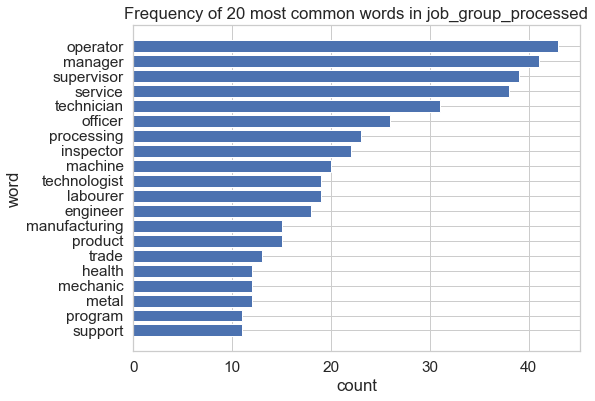

In [16]:
# plot most common words in job titles
sns.set(style='whitegrid', font_scale=1.4)
plot_common_words(train_df, 'job_group_processed', 20)

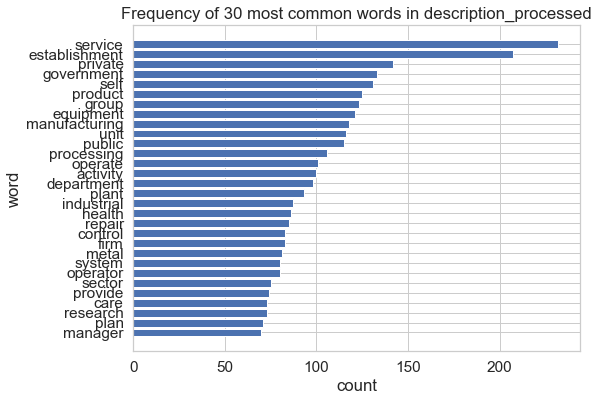

In [17]:
plot_common_words(train_df, 'description_processed', 30)

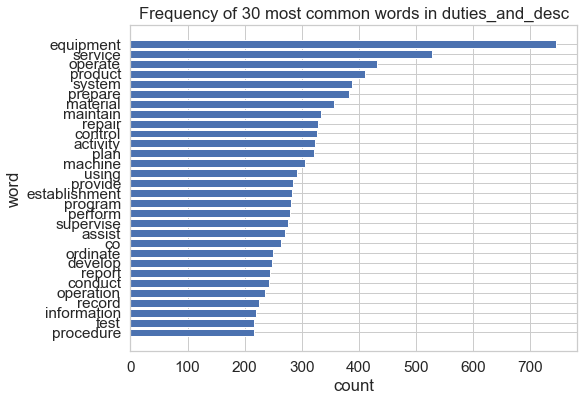

In [18]:
plot_common_words(train_df, 'duties_and_desc', 30)

In [19]:
# vectorize job description - for work_exp df
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=5000)
job_description_vec = vectorizer.fit_transform(train_df['duties_and_desc'])

In [20]:
def multiple_nmf(kmin, kmax, vec_text):
    """run multiple nmf models with a chosen range of number of components,
    return a list XXXXX
    
    kmin -- minimum number of topics
    kmax -- maximum number of topics
    vec_text -- vectorized text
    """
    topic_models = []
    for k in range(kmin, kmax+1):
        print("Applying NMF for k=%d ..." % k)
        nmf = NMF(n_components=k,
                  init="nndsvd",
                  alpha=0.1,
                  random_state=42) 
        W = nmf.fit_transform(vec_text)
        H = nmf.components_    
        topic_models.append((k, nmf, W, H))
    
    return topic_models

In [21]:
topic_models = multiple_nmf(10, 30, job_description_vec)

Applying NMF for k=10 ...
Applying NMF for k=11 ...


/Users/amanda/.virtualenvs/insight/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=12 ...


/Users/amanda/.virtualenvs/insight/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...
Applying NMF for k=16 ...
Applying NMF for k=17 ...
Applying NMF for k=18 ...
Applying NMF for k=19 ...
Applying NMF for k=20 ...
Applying NMF for k=21 ...
Applying NMF for k=22 ...
Applying NMF for k=23 ...
Applying NMF for k=24 ...


/Users/amanda/.virtualenvs/insight/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=25 ...
Applying NMF for k=26 ...
Applying NMF for k=27 ...


/Users/amanda/.virtualenvs/insight/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=28 ...


/Users/amanda/.virtualenvs/insight/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=29 ...


/Users/amanda/.virtualenvs/insight/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=30 ...


In [22]:
# convert job_description_processed to a list of lists for word2vec model
job_desc_train = train_df['duties_and_desc'].apply(lambda x: x.split(' ')).tolist()

# train word2vec model
word2vec_model = Word2Vec(job_desc_train,
                          size=200,
                          window=8,
                          min_count=5,
                          workers=4)

word2vec_model.train(job_desc_train, total_examples=len(job_desc_train), epochs=10)

(523834, 636840)

In [23]:
# have a look at the word2vec results
word2vec_model.wv.most_similar(positive='clean')

[('wash', 0.9415773749351501),
 ('remove', 0.9238792657852173),
 ('feed', 0.9159976840019226),
 ('unload', 0.9137086272239685),
 ('dump', 0.9126605987548828),
 ('load', 0.912160336971283),
 ('move', 0.9062707424163818),
 ('handler', 0.9013651609420776),
 ('disinfect', 0.9013327360153198),
 ('otherwise', 0.8992112874984741)]

In [24]:
def get_top_terms(vectorizer, H, n_top_terms):
    """get terms most important for each of the topics of an nmf model
    return a dictionary with topic number as key and a list of top terms as values
    
    vectorizer -- vectorizer for text
    H -- topic term matrix from nmf model
    n_top_terms -- number of top words to choose
    """
    terms = vectorizer.get_feature_names()
    
    top_terms_dict = {};
    # for each topic, get the largest weights, and save the corresponding words into the dictionary
    num_topics = H.shape[0]
    for i in range(num_topics):
        ids = H[i].argsort()[-n_top_terms:] 
        # word_ids is ordered such that largest weight is the last item, reverse it to have it as first item
        top_terms_dict['Topic '+'{:01d}'.format(i+1)] = [terms[id] for id in reversed(ids)]
        
    return top_terms_dict

def compute_coherence(word2vec_model, top_terms_dict):
    """compute coherence score, ie, mean pairwise similarity of top terms
    
    word2vec_model -- word2vec model trained on words in dataset
    top_term_dict -- top words of each topic (output of get_top_terms() function)
    """
    overall_coherence = 0.0
    num_topics = len(top_terms_dict)
    for i in range(num_topics):
        pair_scores = []
        # compute similarity score for each pair of top words in each topic
        for pair in combinations(top_terms_dict['Topic '+'{:01d}'.format(i+1)], 2):
            try:
                pair_scores.append(word2vec_model.wv.similarity(pair[0], pair[1]))
            except:
                continue
        
        topic_score = sum(pair_scores)/len(pair_scores)
        overall_coherence += topic_score
    
    # get mean score across topics
    return overall_coherence/num_topics

def compare_coherence(topic_models, vectorizer, n_top_terms, word2vec_model):
    """get topic coherence for multiple nmf models
    
    topic_models -- output of multiple_nmf() function
    """
    coherence_dict = {}
    for i in range(len(topic_models)):
        top_terms_dict = get_top_terms(vectorizer, topic_models[i][3], n_top_terms) # 4th element of each list in topic_models: H     
        
        k = topic_models[i][0] # first element of each list in topic models: k
        coherence = compute_coherence(word2vec_model, top_terms_dict)
        print("K=%02d: Coherence=%.4f" % (k, coherence))
        coherence_dict[k] = coherence
        
    return coherence_dict

In [25]:
coherence_dict = compare_coherence(topic_models, vectorizer, 20, word2vec_model)

K=10: Coherence=0.6506
K=11: Coherence=0.6403
K=12: Coherence=0.6540
K=13: Coherence=0.6610
K=14: Coherence=0.6741
K=15: Coherence=0.6729
K=16: Coherence=0.6721
K=17: Coherence=0.6742
K=18: Coherence=0.6839
K=19: Coherence=0.6732
K=20: Coherence=0.6787
K=21: Coherence=0.6652
K=22: Coherence=0.6726
K=23: Coherence=0.6918
K=24: Coherence=0.6958
K=25: Coherence=0.7008
K=26: Coherence=0.6930
K=27: Coherence=0.6875
K=28: Coherence=0.6908
K=29: Coherence=0.6819
K=30: Coherence=0.6831


In [26]:
# get top words for each of 20 topics
best_k = 25
top_words = pd.DataFrame(get_top_terms(vectorizer, topic_models[best_k-10][3], 15))
W = topic_models[best_k-10][2]

In [27]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [28]:
# have a look at top words in each of the 20 topics
top_words

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25
0,co,financial,electrical,metal,patient,insurance,software,processing,construction,railway,food,film,well,social,court,wood,farm,student,animal,fishing,product,direct,aircraft,sport,tree
1,ordinate,senior,equipment,heavy,care,financial,information,plant,engineering,transport,beverage,television,gas,program,law,furniture,livestock,school,laboratory,fish,machine,organize,flight,fitness,forest
2,activity,manager,repair,machine,health,sale,system,process,design,passenger,patron,production,drilling,research,legal,fixture,crop,teacher,veterinarian,vessel,textile,plan,overhaul,event,logging
3,schedule,approve,test,sheet,medical,service,computer,chemical,project,truck,cook,video,oil,client,office,install,poultry,secondary,research,marine,garment,manager,vehicle,recreation,lawn
4,recommend,human,component,product,treatment,customer,data,pulp,building,operate,kitchen,picture,rig,health,officer,using,harvesting,college,conduct,navigational,fur,evaluate,air,athletic,site
5,supervise,resource,system,tool,nursing,credit,telecommunication,mineral,develop,cargo,restaurant,broadcast,drill,service,provincial,repair,agricultural,teach,technologist,seafood,leather,control,inspector,recreational,forestry
6,supervisor,middle,power,part,hospital,investment,network,equipment,engineer,equipment,bar,motion,service,community,administrative,surface,harvest,vocational,trap,crew,fabric,operation,inspect,athlete,landscape
7,contractor,policy,install,mineral,physician,account,develop,control,study,vehicle,chef,theatre,water,policy,document,building,breeding,elementary,veterinary,ship,operate,department,assembly,team,saw
8,requisition,formulate,electronic,machining,nurse,payment,technology,paper,survey,track,serve,radio,petroleum,conduct,property,wooden,general,teaching,chemical,gear,plastic,establishment,mechanic,professional,shrub
9,resolve,director,motor,boiler,disorder,good,application,machinery,conduct,locomotive,staff,camera,equipment,organization,judge,wall,pen,subject,assist,operate,manufacturing,service,mechanical,game,plant


In [30]:
# Initialize dictionary with descriptions for each topic
topic_dict = {'Topic 1':'Supervisory activities',
              'Topic 2':'HR & management',
              'Topic 3':'Electrical repair & installation',
              'Topic 4':'Machinery and manufacturing',
              'Topic 5':'Healthcare',
              'Topic 6':'Sales',
              'Topic 7':'Information technology',
              'Topic 8':'Chemistry',
              'Topic 9':'Construction & civil engineering',
              'Topic 10':'Rail & transportation',
              'Topic 11':'Foodservice',
              'Topic 12':'Media',
              'Topic 13':'Mining and energy',
              'Topic 14':'Public service',
              'Topic 15':'Legal services & administration',
              'Topic 16':'Woodworking & repair',
              'Topic 17':'Farming & agriculture',
              'Topic 18':'Education',
              'Topic 19':'Biological science',
              'Topic 20':'Marine services',
              'Topic 21':'Textile manufacturing',
              'Topic 22':'Management',
              'Topic 23':'Aviation & repair',
              'Topic 24':'Sports and recreation',
              'Topic 25':'Forestry'}

In [31]:
# have a df for document topic matrix, merge with df_work
W = topic_models[best_k-10][2]

topic_weights = pd.DataFrame(W, columns=['Topic '+'{:01d}'.format(i+1) for i in range(best_k)])
topic_weights1 = pd.DataFrame.copy(topic_weights)
# normalize topic weights such that they sum to 1 for each ducoment/job description
topic_weights1 = topic_weights1.div(topic_weights1.sum(axis=1), axis=0)

# find top 3 topics for each document/job description
topic_weights1['highest_topic1'] = topic_weights.idxmax(axis=1)
topic_weights1['highest_topic2'] = topic_weights.T.apply(lambda x: x.nlargest(2).idxmin())
topic_weights1['highest_topic3'] = topic_weights.T.apply(lambda x: x.nlargest(3).idxmin())

df_work_train = pd.concat([train_df, topic_weights1], axis=1, sort=False)

In [32]:
df_work_train.head()

,job_group,noc,description,duties,job_group_processed,description_processed,duties_processed,duties_and_desc,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,highest_topic1,highest_topic2,highest_topic3
0,Legislators,NOC 11,Legislators participate in the activities of a...,"['Enact, amend or repeal laws and regulations'...",legislator,legislator participate activity federal provin...,enact amend repeal law regulation participate ...,legislator participate activity federal provin...,0.000000,0.323187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.172987,0.283753,0.000000,0.0,0.067542,0.0,0.0,0.000000,0.112604,0.0,0.039927,0.0,Topic 2,Topic 15,Topic 14
1,Senior government managers and officials,NOC 12,"Senior government managers and officials plan,...",['Establish objectives for the organization in...,senior government manager official,senior government manager official plan organi...,establish objective organization accordance go...,senior government manager official plan organi...,0.024055,0.746264,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.050038,0.070222,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.109421,0.0,0.000000,0.0,Topic 2,Topic 22,Topic 15
2,"Senior managers - financial, communications an...",NOC 13,"Senior managers in financial, communications a...","[""Determine the company's mission and strategi...",senior manager financial communication busines...,senior manager financial communication busines...,determine mission strategic direction conveyed...,senior manager financial communication busines...,0.000000,0.868472,0.000000,0.001152,0.000000,0.032754,0.019452,0.018856,0.0,0.0,0.000000,0.00000,0.033665,0.000000,0.000000,0.001452,0.0,0.000000,0.0,0.0,0.000000,0.024198,0.0,0.000000,0.0,Topic 2,Topic 13,Topic 6
3,"Senior managers - health, education, social an...",NOC 14,"Senior managers in health, education, social a...",['Establish objectives for the organization or...,senior manager health education social communi...,senior manager health education social communi...,establish objective organization institution f...,senior manager health education social communi...,0.000000,0.787184,0.000000,0.000000,0.026854,0.000000,0.000000,0.000000,0.0,0.0,0.006943,0.00000,0.000000,0.170094,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.008925,0.0,Topic 2,Topic 14,Topic 5
4,"Senior managers - trade, broadcasting and othe...",NOC 15,"Senior managers in trade, broadcasting and oth...",['Establish objectives for the company and for...,senior manager trade broadcasting service,senior manager trade broadcasting customer ser...,establish objective formulate approve policy p...,senior manager trade broadcasting customer ser...,0.017522,0.802117,0.000613,0.000000,0.000000,0.038465,0.000000,0.000000,0.0,0.0,0.056714,0.01298,0.004044,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.009886,0.057659,0.0,0.000000,0.0,Topic 2,Topic 22,Topic 11


In [33]:
# pickle df_work_train, best nmf model, vectorizer
with open('work_exp_train.pkl','wb') as f:
    pickle.dump(df_work_train, f)
with open('vectorizer.pkl','wb') as f:
    pickle.dump(vectorizer, f)
with open('nmf.pkl','wb') as f:
    pickle.dump(topic_models[-6][1], f)


In [43]:
job_name_df.to_csv('/Users/amanda/Documents/Projects/insight/data/processed/model-1.csv', index=False)
df_work_train.to_csv('/Users/amanda/Documents/Projects/insight/data/processed/model-2.csv', index=False)

# Plotting topics in reduced feature space

In [160]:
# reduce 25-d to 2-d for visualization of topics
# tsne with 2 components
tsne = TSNE(n_components=2, random_state=42)
tsne_nmf = tsne.fit_transform(W)



In [161]:
df_work_train['tsne1'] = tsne_nmf[:, 0]
df_work_train['tsne2'] = tsne_nmf[:, 1]

# summary of highest topic: use top 5 words from each topic (each column in nmf_topics df)
df_work_train['topic_sum'] = df_work_train.highest_topic1.apply(lambda x: x + ': ' + ', '.join(top_words.loc[:, x][:5]))



In [162]:
# color mapping for most important topic
topics = ['Topic '+'{:01d}'.format(i+1) for i in range(20)]
colors = ['#ffcc33', '#ff9999', '#ff3333', '#ff9900', '#cc99cc',
          '#996600', '#cc6666', '#cc0033', '#99ccff', '#660066',
          '#336600', '#003366', '#ffff00', '#ccff00', '#999999',
          '#93cbbd', '#0000cc', '#9966cc', '#3399cc', '#ffccff']
color_dict = dict(zip(topics, colors))
df_work_train['color'] = df_work_train.highest_topic1.apply(lambda x: color_dict[x])



In [166]:
# change psych df to bokeh data structure
source = ColumnDataSource(df_work_train)

title = 'T-SNE visualization of topics in descriptions of work experience'

plot_nmf = figure(plot_width=1000, plot_height=800, title=title,
                  tools="pan,wheel_zoom,box_zoom,reset,hover",
                  x_axis_type=None, y_axis_type=None, min_border=1)

plot_nmf.scatter(x='tsne1', y='tsne2', source=source,
                 color='color', alpha=0.6, size=4)

# for i in range(norm_features.shape[1]):
#     plot_nmf.text(topic_coord[i, 0], topic_coord[i, 1], [we['topic_sum'][i]])

# hover tools - display title, agency of each job post
hover = plot_nmf.select(dict(type=HoverTool))
hover.tooltips = {"Work experience": "Title: @job_title_processed"}

show(plot_nmf)

# Add feature to add a hobby of interest

In [34]:
hobby_df = pd.read_csv(os.path.join(data_path,'processed','hobby-descriptions.csv'))

In [35]:
# preprocess job title and description
df = pickle.load(open('work_exp_train.pkl', 'rb'))
vectorizer = pickle.load(open('vectorizer.pkl', 'rb'))
nmf = pickle.load(open('nmf.pkl', 'rb'))

In [36]:
#model = topic_models[best_k-10][3]

zero_data = np.zeros(shape=(len(hobby_df),best_k))
hobby_topics = pd.DataFrame(zero_data, columns=topic_dict.keys())

for i, description in enumerate(hobby_df['description']):
    print(hobby_df.iloc[i,0])
    desc = preprocess(description)
    desc_vec = vectorizer.transform([desc])
    # get topic weights for description of current job
    desc_nmf = nmf.transform(desc_vec)
    # normalize topic weights so that they sum up to 1 
    desc_nmf = desc_nmf/np.sum(desc_nmf)
    
    hobby_topics.loc[i,:] = desc_nmf
    
df = pd.concat([hobby_df, hobby_topics], axis=1)

3D printing
Acrobatics
Acting
Amateur radio
Animation
Aquascaping
Astrology
Astronomy
Baking
Baton twirling
Blog
Building
Board game
Book discussion club
Book restoration
Bowling
Brazilian jiu-jitsu
Bread
Bullet Journal
Cabaret
Calligraphy
History of candle making
Candy making
Car
Card game
Cheesemaking
Cleaning
Clothing
Home roasting coffee
Collecting
Coloring book
Computer programming
Confectionery
Cooking
Cosplay
Coupon
Craft
Creative writing
Crochet
Cross-stitch
Crossword
Cryptography
Cue sports
Dance
Digital art
Linux distribution
Disc jockey
Do it yourself
Drama
Drawing
Mixed drink
Electronic game
Electronics
Embroidery
Experiment
Fantasy sport
Fashion
Fashion design
Fishkeeping
Floral design
Fly tying
Second-language acquisition
Furniture
Game
Tabletop game
Role-playing game
Genealogy
Gingerbread house
Glassblowing
Graphic design
Gunsmith
Gymnastics
Hacker
Herpetoculture
Home improvement
Homebrewing
Houseplant care
Hula hoop
Hydroponics
Ice skating
Jewellery design
Jigsaw puzzle

/Users/amanda/.virtualenvs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Element collecting
Ephemera
Telephone card
Knife collecting
Lottery
Film memorabilia
Perfume
Phillumeny
Rail transport modelling
Record collecting
Tumble finishing
Patch collecting
Shoe
Sports memorabilia
Stamp collecting
Stuffed toy
Tea bag
Ticket (admission)
Toy
Video game collecting
Vintage car
Vintage clothing
Phonograph record
Antiquities
Vehicle audio
Pressed flower craft
Fossil collecting
Insect collecting
Magnet fishing
Metal detector
Mineral collecting
Rock balancing
Sea glass
Seashell
Amateur geology
Animal fancy
Axe throwing
Backgammon
Badminton
Baton twirling
Beauty pageant
Cue sports
Bowling
Boxing
Contract bridge
Draughts
Cheerleading
Chess
Color guard (flag spinning)
Cribbage
Curling
Competitive dance
Darts
Debate
Dominoes
Competitive eating
Esports
Fencing
Go (game)
Gymnastics
Ice hockey
Ice skating
Judo
Jujutsu
Kabaddi
Word game
Laser tag
Longboarding
Mahjong
Marble (toy)
Martial arts
Model United Nations
Poker
Pool (cue sports)
Role-playing game
Shogi
Slot car racing


In [37]:
len(hobby_topics)

463

In [38]:
df

,hobby,description,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25
0,3D printing,"3D printing, or additive manufacturing, is the...",0.024470,0.014608,0.000000,0.073503,0.000000,0.013062,0.038499,0.080473,0.149621,0.000000,0.000000,0.355113,0.000000,0.000000e+00,0.000000,0.047458,0.000000,0.004329,0.000000,0.000000,0.197922,0.000000,0.000941,0.000000,0.000000
1,Acrobatics,"Acrobatics (from Ancient Greek ἀκροβατέω, akro...",0.044889,0.202052,0.042747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022306,0.000000,0.156076,0.000000,0.000000e+00,0.179425,0.034268,0.000000,0.057894,0.000000,0.000000,0.000000,0.000000,0.010890,0.249454,0.000000
2,Acting,Acting is an activity in which a story is told...,0.000000,0.000000,0.000000,0.000000,0.027813,0.000000,0.000000,0.000000,0.002784,0.000000,0.000000,0.487475,0.101842,6.127697e-02,0.000000,0.000000,0.000000,0.235542,0.000000,0.000000,0.000000,0.008801,0.003281,0.071185,0.000000
3,Amateur radio,"Amateur radio, also known as ham radio, is the...",0.000000,0.000000,0.023440,0.000000,0.000000,0.085042,0.011709,0.000000,0.000000,0.034419,0.000000,0.311800,0.018697,9.963459e-02,0.092481,0.000000,0.000000,0.000000,0.001718,0.011713,0.000000,0.086308,0.060696,0.156474,0.005869
4,Animation,Animation is a method in which figures are man...,0.000000,0.000000,0.000000,0.045689,0.012753,0.000000,0.242856,0.000000,0.000000,0.000000,0.000000,0.658814,0.000000,0.000000e+00,0.000000,0.039888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Aquascaping,Aquascaping is the craft of arranging aquatic ...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.202215,0.026828,0.000000,0.000000,0.006494,0.181204,0.000000e+00,0.000000,0.000000,0.042192,0.009035,0.002861,0.446487,0.011593,0.000000,0.000000,0.019475,0.051616
6,Astrology,Expand listfor referenceAstrology is a pseudos...,0.000000,0.062828,0.102014,0.002482,0.000000,0.036878,0.334712,0.006366,0.000000,0.000000,0.000000,0.055761,0.000000,0.000000e+00,0.000000,0.008724,0.000000,0.000000,0.000000,0.018898,0.000000,0.000000,0.061755,0.309583,0.000000
7,Astronomy,Astronomy (from Greek: ἀστρονομία) is a natura...,0.000000,0.000000,0.000000,0.038837,0.056638,0.017943,0.000000,0.000000,0.282420,0.000000,0.004871,0.066040,0.005779,2.711700e-01,0.039788,0.005113,0.000000,0.094909,0.103311,0.000000,0.000000,0.000000,0.000000,0.013180,0.000000
8,Baking,Baking is a method of preparing food that uses...,0.000000,0.000000,0.000000,0.046105,0.000000,0.068491,0.000000,0.000000,0.000000,0.036743,0.487503,0.083262,0.000000,1.124293e-01,0.000000,0.057495,0.000000,0.017806,0.000000,0.000000,0.083744,0.000000,0.000000,0.006423,0.000000
9,Baton twirling,Baton twirling is an art involving the manipul...,0.000000,0.000000,0.006248,0.152845,0.010228,0.002959,0.000000,0.000000,0.000000,0.023287,0.000000,0.163066,0.000000,0.000000e+00,0.000000,0.018614,0.000000,0.370009,0.000000,0.000000,0.016302,0.000000,0.036142,0.200301,0.000000


In [39]:
df.to_pickle(os.path.join(data_path,'processed','hobby-topics.pkl'))

In [40]:
from scipy import spatial
def uniqueness(df1,df2,group,hobby_df,hobby):
    
    hobby_multiplier = 5

    group_jobs = df1.where(df1['education_groups']==group).dropna().drop_duplicates(['top_jobs'])

    is_job = df2[df2.noc.isin(group_jobs['noc'])]
    job_scores = is_job.iloc[:,-28:-3]
    not_job = df2[~df2.noc.isin(group_jobs['noc'].values)]
    
    hobby_topics = hobby_df.where(hobby_df['hobby']==hobby).dropna()
    hobby_scores = hobby_topics.iloc[:,-25:] * hobby_multiplier

    job_mean = list((is_job.iloc[:,-28:-3]).mean(axis=0, skipna=True))
    unique_mean = pd.concat([job_scores, hobby_scores], axis=0).mean(axis=0, skipna=True)

    unique_mean = unique_mean/np.sum(unique_mean)
    
    for i in range(1,len(unique_mean)):
        print("{:.4f} -> {:.4f}".format(job_mean[i],unique_mean[i]))

    results = []
    similarity = []
    for i in range(len(not_job)):
        b = not_job.iloc[i,-28:-3]
        c_sim = 1 - spatial.distance.cosine(unique_mean, b)
        similarity.append(c_sim)

    not_job['similarity'] = similarity

    sorted_df = not_job.sort_values(by=['similarity'],ascending=False)

    results = sorted_df['job_group'][0:10]

    return list(results)
    

In [41]:
job_name = 'Sociology'
hobby_name = 'Collecting'

results = uniqueness(job_name_df,df_work_train,job_name,df,hobby_name)

results

0.0446 -> 0.0345
0.0012 -> 0.0009
0.0008 -> 0.0043
0.0233 -> 0.0238
0.0929 -> 0.1133
0.0469 -> 0.0563
0.0046 -> 0.0035
0.0221 -> 0.0171
0.0019 -> 0.0073
0.0101 -> 0.0171
0.0073 -> 0.0203
0.0111 -> 0.0085
0.2724 -> 0.2116
0.0374 -> 0.0401
0.0007 -> 0.0390
0.0053 -> 0.0049
0.2622 -> 0.2453
0.0198 -> 0.0205
0.0011 -> 0.0009
0.0084 -> 0.0147
0.0628 -> 0.0485
0.0000 -> 0.0000
0.0279 -> 0.0399
0.0001 -> 0.0001


/Users/amanda/.virtualenvs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
